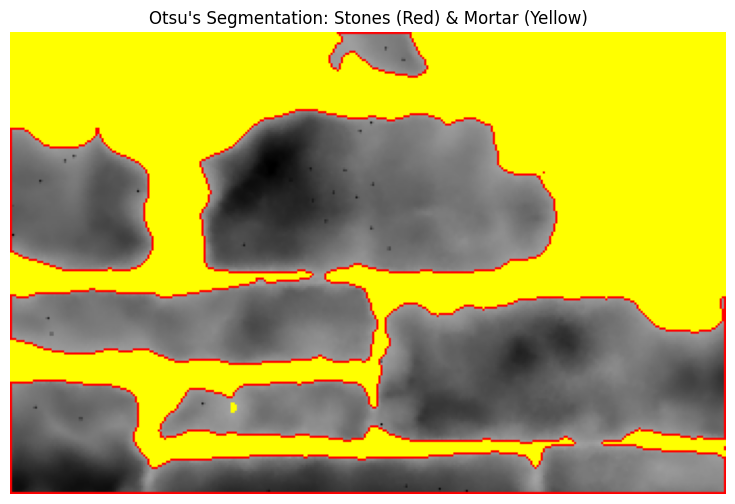

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the depth map image (grayscale)
depth_map_path = r"D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\image_copy.png"
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise before thresholding
blurred = cv2.GaussianBlur(depth_map, (5, 5), 0)

# Apply Otsu's thresholding
_, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Stones are assumed to be darker (lower intensity), so invert the mask if needed
# Here, we assume dark pixels are stones. Invert if mortar appears as black.
stone_mask = (otsu_thresh == 0).astype(np.uint8) * 255
mortar_mask = (otsu_thresh == 255).astype(np.uint8) * 255

# Find contours of the stone regions
stone_contours, _ = cv2.findContours(stone_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create color overlay for visualization
segmentation_overlay = cv2.cvtColor(depth_map, cv2.COLOR_GRAY2BGR)

# Draw red contours for stones
cv2.drawContours(segmentation_overlay, stone_contours, -1, (255, 0, 0), 1)

# Highlight mortar areas in yellow
segmentation_overlay[mortar_mask > 0] = [255, 255, 0]

# Display results
plt.figure(figsize=(10, 6))
plt.imshow(segmentation_overlay)
plt.title("Otsu's Segmentation: Stones (Red) & Mortar (Yellow)")
plt.axis("off")
plt.show()


Introduce manual threshold

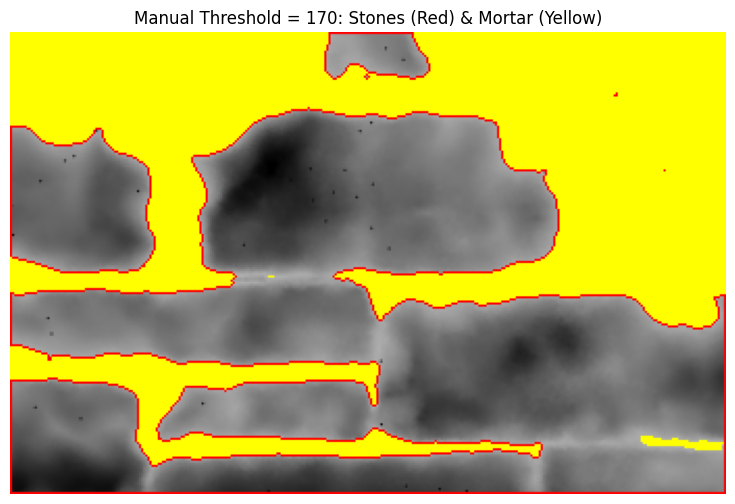

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the depth map image (grayscale)
depth_map_path = r"D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\image_copy.png"
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)

if depth_map is None:
    raise FileNotFoundError(f"Could not load image from {depth_map_path}")

# Apply Gaussian blur to reduce noise before thresholding
blurred = cv2.GaussianBlur(depth_map, (5, 5), 0)

# === Manual Threshold Control ===
manual_thresh_value = 170  # ← CHANGE THIS to adjust stone intensity cutoff (try 90–140)
_, manual_thresh = cv2.threshold(blurred, manual_thresh_value, 255, cv2.THRESH_BINARY)

# Stones = dark regions (below threshold), so we invert the binary result
stone_mask = (manual_thresh == 0).astype(np.uint8) * 255
mortar_mask = (manual_thresh == 255).astype(np.uint8) * 255

# Find contours of the stone regions
stone_contours, _ = cv2.findContours(stone_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create color overlay for visualization
segmentation_overlay = cv2.cvtColor(depth_map, cv2.COLOR_GRAY2BGR)

# Draw red contours for stones (BGR: (0, 0, 255))
cv2.drawContours(segmentation_overlay, stone_contours, -1, (0, 0, 255), 1)

# Highlight mortar areas in yellow (BGR: (0, 255, 255))
segmentation_overlay[mortar_mask > 0] = [0, 255, 255]

# Display results
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(segmentation_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Manual Threshold = {manual_thresh_value}: Stones (Red) & Mortar (Yellow)")
plt.axis("off")
plt.show()


Introduce adaptive thresholding approach

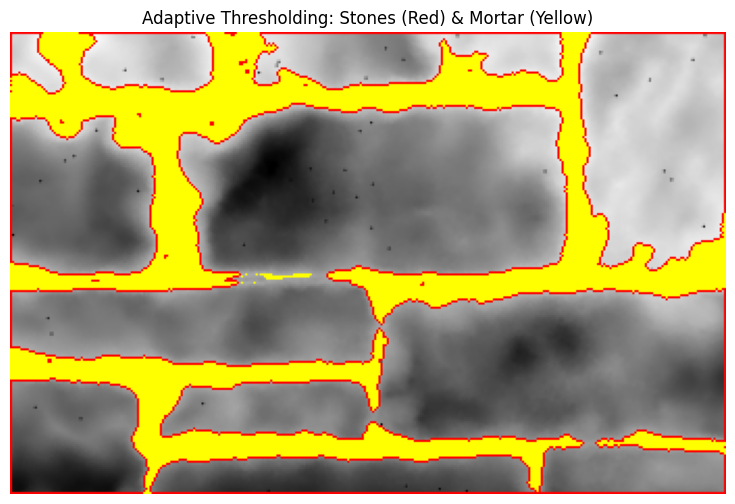

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the depth map image (grayscale)
depth_map_path = r"D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\image_copy.png"
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)

if depth_map is None:
    raise FileNotFoundError(f"Could not load image from {depth_map_path}")

# Apply Gaussian blur to reduce noise before thresholding
blurred = cv2.GaussianBlur(depth_map, (1, 1), 0)
# blurred = cv2.medianBlur(depth_map, 5)

# === Adaptive Thresholding (local contrast based) ===
# Stones are assumed to be darker (so we invert the binary map)
adaptive_thresh = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,  # invert so dark (stone) = white
    blockSize = 275,  # must be odd; higher = larger area to compute local mean
    C= -40 # fine-tune this to adjust segmentation sensitivity
)

# Generate masks
stone_mask = adaptive_thresh
mortar_mask = cv2.bitwise_not(adaptive_thresh)  # inverse of stone mask

# Find contours of the stone regions
stone_contours, _ = cv2.findContours(stone_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create color overlay for visualization
segmentation_overlay = cv2.cvtColor(depth_map, cv2.COLOR_GRAY2BGR)

# Draw red contours for stones (BGR: (0, 0, 255))
cv2.drawContours(segmentation_overlay, stone_contours, -1, (0, 0, 255), 1)

# Highlight mortar areas in yellow (BGR: (0, 255, 255))
segmentation_overlay[mortar_mask > 0] = [0, 255, 255]

# Display results
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(segmentation_overlay, cv2.COLOR_BGR2RGB))
plt.title("Adaptive Thresholding: Stones (Red) & Mortar (Yellow)")
plt.axis("off")
plt.show()


Generation of Ground Truth Binary Mask

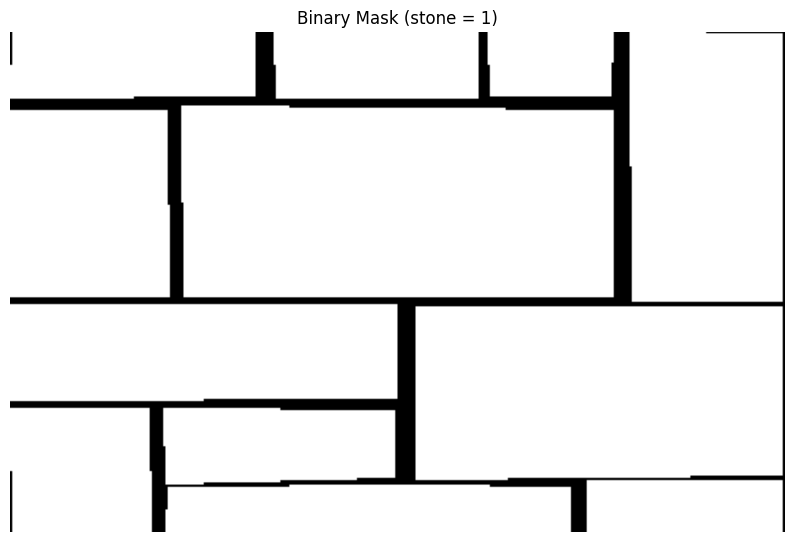

Mask saved to: D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\stones_labels_JSON_binary_mask.png


In [3]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# --- 1. Load the LabelMe JSON annotation ---
json_path = r'D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\stones_labels_JSON.json'
with open(json_path, 'r') as f:
    data = json.load(f)

# --- 2. Extract image dimensions ---
image_path = data['imagePath']
imageHeight = data['imageHeight']
imageWidth = data['imageWidth']

# --- 3. Create an empty mask ---
mask = np.zeros((imageHeight, imageWidth), dtype=np.uint8)

# --- 4. Loop through the annotations and fill polygons labelled 'stone' ---
for shape in data['shapes']:
    if shape['label'].lower() == 'stone':
        # Get polygon points as numpy array
        points = np.array(shape['points'], dtype=np.int32)
        # Fill the polygon with 1s
        cv2.fillPoly(mask, [points], 1)

# --- 5. Visualize the mask ---
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title("Binary Mask (stone = 1)")
plt.axis('off')
plt.show()

# --- 6. Save the mask as an image ---
mask_output_path = json_path.replace('.json', '_binary_mask.png')
Image.fromarray(mask * 255).save(mask_output_path)
print(f"Mask saved to: {mask_output_path}")


Computation of Evaluation Metrics and Confusion Map


Segmentation Evaluation Metrics:
True Positive (stone): 59035
False Negative (missed stone): 10548
False Positive (mortar as stone): 963
True Negative (mortar): 5822
Accuracy: 0.8493
Precision: 0.9839
Recall: 0.8484
F1 Score: 0.9112
IoU (Jaccard): 0.8368


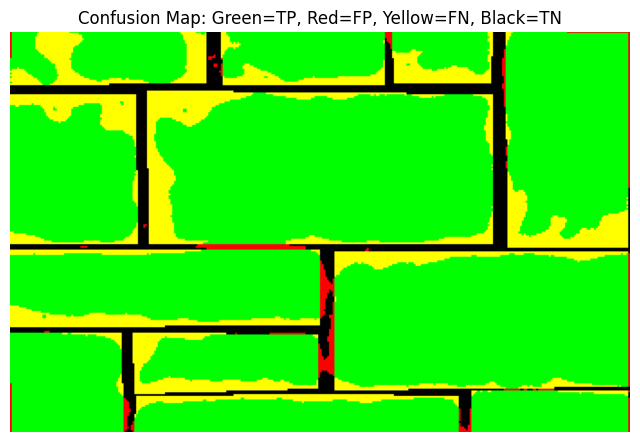

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# === Load the depth map ===
depth_map_path = r"D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\image_copy.png"
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)

if depth_map is None:
    raise FileNotFoundError(f"Could not load image from {depth_map_path}")

# === Adaptive Thresholding for segmentation ===
blurred = cv2.GaussianBlur(depth_map, (1, 1), 0)
adaptive_thresh = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    blockSize=275,
    C=-40
)

# Stone = white (255), Mortar = black (0)
stone_mask = adaptive_thresh
mortar_mask = cv2.bitwise_not(stone_mask)

# === Create predicted binary mask (1 = stone, 0 = mortar) ===
# Fill stone contours
stone_contours, _ = cv2.findContours(stone_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
predicted_mask = np.zeros_like(stone_mask, dtype=np.uint8)
cv2.drawContours(predicted_mask, stone_contours, -1, 1, thickness=cv2.FILLED)

# === Load ground truth mask ===
gt_mask_path = r"D:\CloudCompare_RGB_D\CloudCompare\Montgomery_Street_Garden_Wall\Depth_Map\stones_labels_JSON_binary_mask.png"
gt_mask = np.array(Image.open(gt_mask_path).convert("L"))
gt_mask = (gt_mask > 127).astype(np.uint8)  # Ensure binary

# === Evaluation Function ===
def evaluate_segmentation(pred_mask, gt_mask, verbose=True):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    cm = confusion_matrix(gt_flat, pred_flat, labels=[1, 0])
    TP = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TN = cm[1, 1]

    accuracy  = accuracy_score(gt_flat, pred_flat)
    precision = precision_score(gt_flat, pred_flat, zero_division=0)
    recall    = recall_score(gt_flat, pred_flat, zero_division=0)
    f1        = f1_score(gt_flat, pred_flat, zero_division=0)
    iou       = jaccard_score(gt_flat, pred_flat, zero_division=0)

    results = {
        'True Positive (stone)': TP,
        'False Negative (missed stone)': FN,
        'False Positive (mortar as stone)': FP,
        'True Negative (mortar)': TN,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'IoU (Jaccard)': iou
    }

    if verbose:
        print("\nSegmentation Evaluation Metrics:")
        for k, v in results.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    return results

# === Run evaluation ===
evaluate_segmentation(predicted_mask, gt_mask)

# === (Optional) Visualize confusion map ===
def visualize_confusion(pred_mask, gt_mask):
    conf_map = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)

    conf_map[(gt_mask == 1) & (pred_mask == 1)] = [0, 255, 0]     # TP = green
    conf_map[(gt_mask == 0) & (pred_mask == 0)] = [0, 0, 0]       # TN = black
    conf_map[(gt_mask == 0) & (pred_mask == 1)] = [255, 0, 0]     # FP = red
    conf_map[(gt_mask == 1) & (pred_mask == 0)] = [255, 255, 0]   # FN = yellow

    plt.figure(figsize=(8, 8))
    plt.imshow(conf_map)
    plt.title("Confusion Map: Green=TP, Red=FP, Yellow=FN, Black=TN")
    plt.axis("off")
    plt.show()

# === Show confusion visualization ===
visualize_confusion(predicted_mask, gt_mask)


Computation of TPLF

In [5]:
# Compute TPLF (True Positive Localization Fraction)
def compute_tplf(tp, fn):
    if (tp + fn) == 0:
        return 0.0
    return tp / (tp + fn)

# Example usage (replace these values with your actual results)
TP = 59035  # True Positives
FN = 10548   # False Negatives
TPLF = compute_tplf(TP, FN)
print(f"TPLF = {TPLF:.4f}")

TPLF = 0.8484


Computation of FPR

In [6]:

# Compute FPR (False Positive Rate)
def compute_fpr(fp, tp):
    if (tp + fp) == 0:
        return 0.0
    return fp / (tp + fp)

# Example usage (replace these values with your actual results)
FP = 963   # False Positives
TP = 59035  # True Positives
FPR = compute_fpr(FP, TP)
print(f"FPR = {FPR:.4f}")


FPR = 0.0161
